# Analysis of Yelp Business Intelligence Data
We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from Kaggle although we have taken steps to pull this data into a publis s3 bucket: s3://sta9760-yelpdataset/yelp-light/*business.json

# Installation and Initial Setup
We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from Kaggle although we have taken steps to pull this data into a publis s3 bucket: s3://sta9760-yelpdataset/yelp-light/*business.json

In [1]:
%info

In [2]:
sc.install_pypi_package("pandas==1.0.3")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1588514591184_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
sc.install_pypi_package("matplotlib==3.2.1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
sc.install_pypi_package("seaborn==0.10.0")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Importing
Now, import the installed packages from the previous block below.

In [55]:
import pandas
import seaborn
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1
boto                       2.49.0
cycler                     0.10.0
jmespath                   0.9.4
kiwisolver                 1.2.0
lxml                       4.4.2
matplotlib                 3.2.1
mysqlclient                1.4.6
nltk                       3.4.5
nose                       1.3.4
numpy                      1.14.5
pandas                     1.0.3
pip                        20.1
py-dateutil                2.2
pyparsing                  2.4.7
python-dateutil            2.8.1
python36-sagemaker-pyspark 1.2.6
pytz                       2019.3
PyYAML                     3.11
setuptools                 46.1.3
six                        1.13.0
soupsieve                  1.9.5
wheel                      0.34.2
windmill                   1.6

## Loading Data
We are finally ready to load data. Using spark load the data from S3 into a dataframe object that we can manipulate further down in our analysis.

In [5]:

df1 = spark.read.json('s3://2yelp-academic-dataset-business/yelp_academic_dataset_business.json')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:

df2 = spark.read.json('s3://2yelp-academic-dataset-business/yelp_academic_dataset_review.json')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data
Display the number of rows and columns in our dataset.

In [7]:
print(f'Total Columns:{len(df1.dtypes)}')
print(f'Total Rows: {df1.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns:14
Total Rows: 209,393

Display the DataFrame schema below.

In [8]:
df1.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

business_id
name
city
state
categories

In [11]:
df1.createOrReplaceTempView('yelp_data1')

sqldf1 = spark.sql(
'''
SELECT business_id,name,city,state,categories FROM yelp_data1
limit 5
'''
)
sqldf1.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+--------------------+
|         business_id|                name|           city|state|          categories|
+--------------------+--------------------+---------------+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+--------------------+

# Analyzing Categories

Let's now answer this question: how many unique categories are represented in this dataset?

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

How many businesses are categorized as Active Life, for instance
What are the top 20 most popular categories available?

## Association Table
We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

In [12]:
from pyspark.sql.functions import split, explode

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
df1_split=df1.select(['business_id', 'categories'])
df1_split=df1_split.select("business_id", explode(split("categories", ", ")).alias("category"))
df1_split.limit(5).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|        category|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+

## Total Unique Categories


In [61]:
df1_split.select('category').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

## Top Categories By Business
### Counts of Businesses/Category

In [64]:
df1_split.createOrReplaceTempView('split_data')

top20=spark.sql(
'''
SELECT 'category', COUNT(category) as count FROM split_data
GROUP BY category
''')
top20.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+-----+
|category|count|
+--------+-----+
|category|  341|
|category|   54|
|category|   16|
|category|   36|
|category|   21|
|category|   28|
|category|  104|
|category|    1|
|category|   54|
|category|  195|
|category|   34|
|category|  169|
|category|   49|
|category|  100|
|category|   74|
|category|   13|
|category|  828|
|category| 2880|
|category|  312|
|category|    8|
+--------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

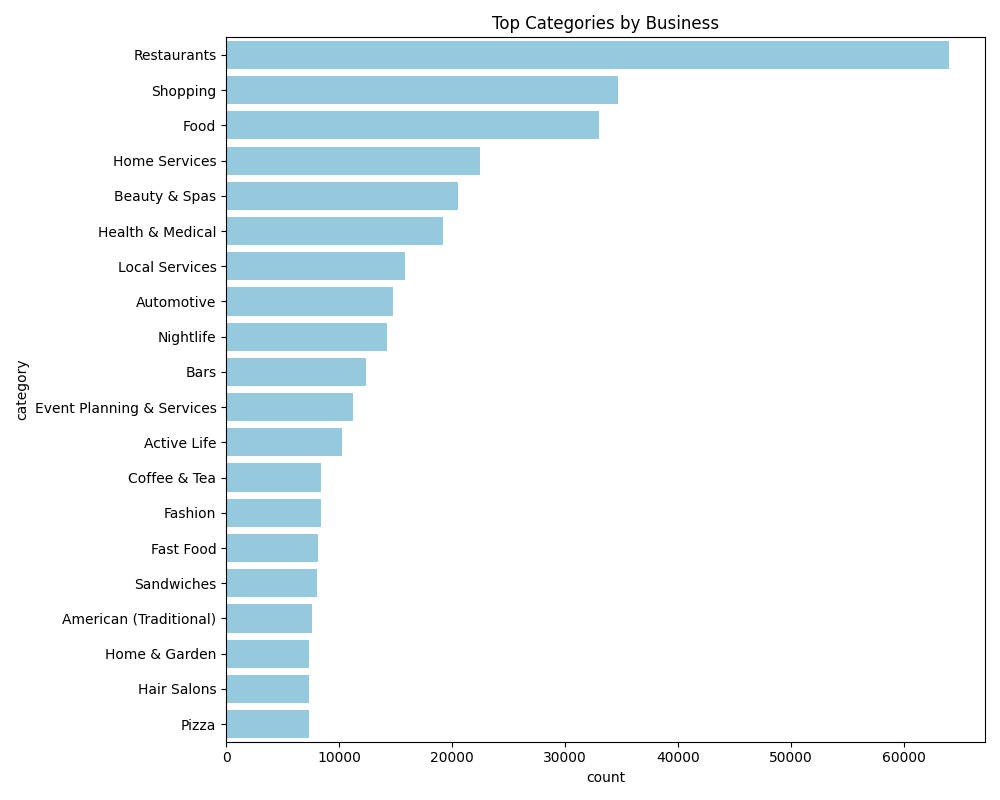

In [66]:
chart_top=df1_split.groupBy('category').count().orderBy('count', ascending=False).limit(20)
fig, ax = plt.subplots(figsize = (10, 8))
ax.set_title('Top Categories by Business')
plot = seaborn.barplot(x = 'count', y = 'category', data = chart_top.toPandas(), ax = ax, color = 'skyblue')
plot.figure.tight_layout()

%matplot plt

# Do Yelp Reviews Skew Negative?
Oftentimes, it is said that the only people who write a written review are those who are extremely dissatisfied or extremely satisfied with the service received.

## Loading User Data
Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [16]:
df2 = spark.read.json('s3://2yelp-academic-dataset-business/yelp_academic_dataset_review.json')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
df2.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

In [17]:
df2.createOrReplaceTempView('df2_data')

sqldf2 = spark.sql(
'''
SELECT business_id,stars FROM df2_data
limit 5
'''
)
sqldf2.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+

In [47]:
avg_review = spark.sql(
'''
SELECT
  business_id,
  AVG(stars) as avg
FROM df2_data
GROUP BY business_id
'''
)
avg_review.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|               avg|
+--------------------+------------------+
|ATeOjZzE3VOI-RW7F...| 3.433734939759036|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vbUABNAQI2iwN7v0x...|2.4545454545454546|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+
only showing top 5 rows

In [51]:
table = df1.select(['stars', 'name', 'city', 'state', 'business_id'])
table = avg_review.join(table, 'business_id', 'inner').drop('business_id')
table.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+-----------+-----+
|               avg|stars|                name|       city|state|
+------------------+-----+--------------------+-----------+-----+
|  4.11784140969163|  4.0|Delmonico Steakhouse|  Las Vegas|   NV|
|2.3333333333333335|  2.5|Neo-Paws Internat...|    Toronto|   ON|
|             4.375|  4.5| McFarling Law Group|  Las Vegas|   NV|
|3.3333333333333335|  3.5|Volvo of Mississauga|Mississauga|   ON|
|               5.0|  5.0|Andre Agassi Coll...|  Las Vegas|   NV|
+------------------+-----+--------------------+-----------+-----+
only showing top 5 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

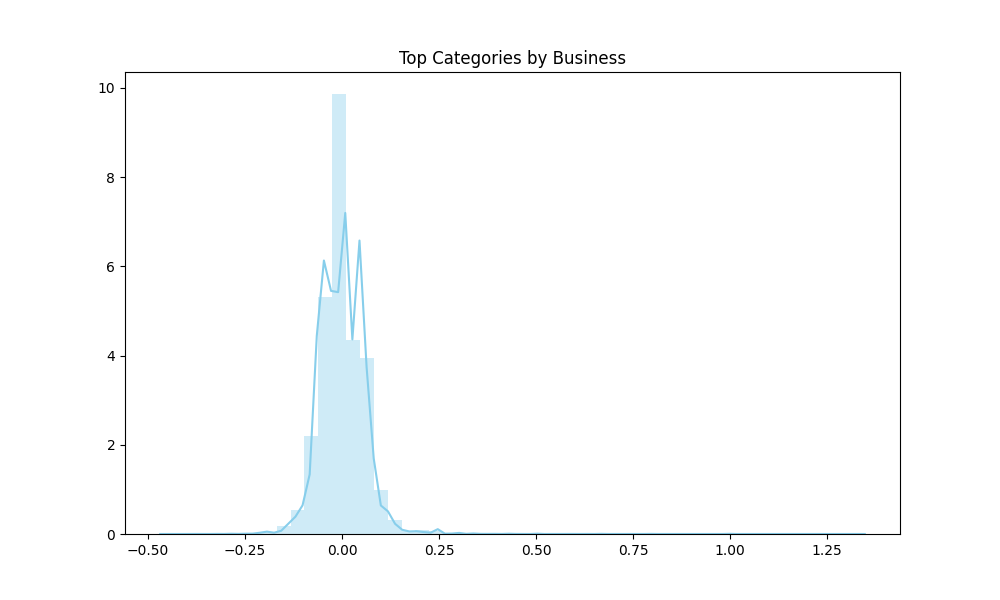

In [56]:
skew_data = table.withColumn('skew', (table.avg - table.stars) / table.stars)
fig, ax = plt.subplots(figsize = (10, 6))
seaborn.distplot(skew_data.select('skew').toPandas(), ax = ax, color = 'skyblue')
ax.set_title('Top Categories by Business')

%matplot plt

This plot shows the yelp reviews don't skew negative. They are distributed around the right side of 0. It may mean the reviews skew positive.

# Should the Elite be Trusted? (Or, some other analysis of your choice)

In [57]:
df3 = spark.read.json('s3://2yelp-academic-dataset-business/yelp_academic_dataset_user.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
df3.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [68]:
elite_data = df3.select(['user_id', 'elite'])
subset = df2.select(['business_id', 'user_id', 'stars', 'date'])
subset = subset.join(elite_data, 'user_id', 'inner').drop('user_id')
subset.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+-------------------+--------------------+
|         business_id|stars|               date|               elite|
+--------------------+-----+-------------------+--------------------+
|pmrHuQiy25xKB86tb...|  4.0|2014-03-21 17:09:59|                    |
|QhwaGi1niDeVEHMRt...|  2.0|2012-07-06 03:43:34|                    |
|L772e6l2Yd0DJEyCB...|  4.0|2014-09-19 01:12:10|2011,2012,2013,20...|
|DyYS-JKXlW2PCr_Gt...|  5.0|2017-05-01 16:05:57|                    |
|sAS4fHDiK8A9a1wEA...|  1.0|2014-08-28 01:31:40|                    |
+--------------------+-----+-------------------+--------------------+
only showing top 5 rows

In [70]:
subset = subset.withColumn('year', subset.date.substr(1, 4))
df_review = subset.filter(subset.elite.contains(subset.year))
df_review.createOrReplaceTempView('review_data')

elite_avg = spark.sql(
'''
SELECT business_id, AVG ( `stars`) as avgstars FROM review_data
GROUP BY `business_id`
'''
)

elite_avg.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------------+
|         business_id|         avgstars|
+--------------------+-----------------+
|eKznX8VTfcQrjCqXp...|4.279411764705882|
|--9e1ONYQuAa-CB_R...|4.240641711229946|
|GGxnlrfvWy7LFvjN5...|4.222222222222222|
|1bPL4k_Ti8to01tI_...|              3.5|
|_ixV2SWDy7w8jzEAH...|3.780952380952381|
+--------------------+-----------------+
only showing top 5 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

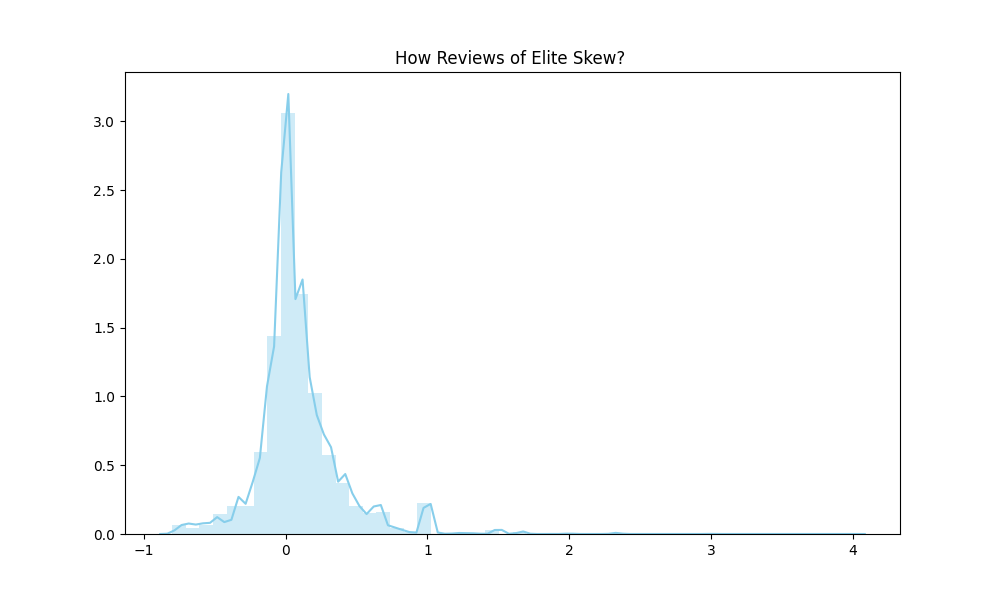

In [71]:
subset1 = df1.select(['stars', 'business_id'])
subset1 = elite_avg.join(subset1, 'business_id', 'inner').drop('business_id')
elite1 = subset1.withColumn('skew', (subset1.avgstars - subset1.stars) / subset1.stars)
fig, ax = plt.subplots(figsize = (10, 6))
seaborn.distplot(elite1.select('skew').toPandas(), ax = ax, color = 'skyblue')
ax.set_title('How Reviews of Elite Skew? ')

%matplot plt

From this plot, we can see that the reviews from elite skew more positive than the reviews from customers. They may always give higher rating. So we need to use their ratings rationally.